In [1]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import os
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import matplotlib.patches as patches
from PIL import Image
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import cv2

%matplotlib inline

# Get current/root directory
root = os.getcwd()

print("Using PyTorch Version %s" %torch.__version__)

Using PyTorch Version 1.4.0


In [2]:
# Hyper-parameter settings
TOTAL_EPOCH = 200
LEARNING_RATE = 0.001
MOMENTUM = 0.9
BATCH_SIZE = 5

class_arr = [0,1]

In [3]:
# Veriables
feature_map = []
classes = [] # Catheter: 1, Echo: 0
data_count = 0

mags = []
phases = []
sectors = []
distances = []
sigs = []

cat_data = []
echo_data = []

# Read train data
train_loc = 'D:/SCA/256_256/feature_map/train'
train_files = [f for f in listdir(train_loc) if isfile(join(train_loc, f))]

print('Loading train data...')

for file in train_files:
    f_arr = file.split('_')
    otype = f_arr[3]
    
    lbl = 1 if otype == 'c' else 0
    
    dataset=pd.read_csv(train_loc + '/' + file, header=None, delimiter='\t')   
    dataset = dataset.values
    
    one_object_features = []
    
    d_count = 0
    
    for ds in dataset:
        # Order: magnitude(0), phase(1), signature(2), sector(3), distance(4)
        if d_count <= 39:
            
            o_arr = ds[0].split(',')
            o_arr = np.array(o_arr)
            o_arr = o_arr.astype(np.float)

            mags.append(o_arr[0])
            phases.append(o_arr[1])
            sectors.append(o_arr[3])
            distances.append(o_arr[4])
            sigs.append(o_arr[2])

            for o in o_arr:
                one_object_features.append(o)
                
            d_count += 1
            
            if d_count == 39:
                continue
            
            
    one_object_features = np.array(one_object_features)
    
    # Data normalization
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(one_object_features.reshape(-1, 1))
    
    feature_map.append(scaled_data)
    classes.append(lbl)
    
    if lbl == 1:
        cat_data.append(scaled_data)
        echo_data.append(scaled_data)
    else:
        echo_data.append(scaled_data)
    
    data_count = data_count + 1
    print('\r' + str(data_count) + ' out of ' + str(len(train_files)), end='')
    
feature_map = np.array(feature_map)
classes = np.array(classes)

print('\nDone!')

Loading train data...
38310 out of 38310
Done!


In [41]:
# Load test data

# Veriables
test_feature_map = []
test_classes = [] # Catheter: 1, Echo: 0
test_files_title = []
data_count = 0

# Read test data
test_loc = 'D:/SCA/256_256/feature_map/test'
test_files = [f for f in listdir(test_loc) if isfile(join(test_loc, f))]

print('Loading test data...')

for file in test_files:
    f_arr = file.split('_')
    otype = f_arr[3]
    
    lbl = 1 if otype == 'c' else 0
    
    dataset=pd.read_csv(test_loc + '/' + file, header=None, delimiter='\t')   
    dataset = dataset.values
    
    one_object_features = []
    d_count = 0
    
    for ds in dataset:
        # Order: magnitude(0), phase(1), signature(2), sector(3), distance(4)
        
        if d_count <= 39:
            o_arr = ds[0].split(',')
            o_arr = np.array(o_arr)
            o_arr = o_arr.astype(np.float)

            for o in o_arr:
                one_object_features.append(o)
            
            d_count += 1
            
            if d_count == 39:
                continue
            
    data_count = data_count + 1
    print('\r' + str(data_count) + ' out of ' + str(len(test_files)), end='')
         
    one_object_features = np.array(one_object_features)
    
    # Data normalization
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(one_object_features.reshape(-1, 1))
    
    test_feature_map.append(scaled_data)
    test_classes.append(lbl)
    test_files_title.append(file)
    
test_feature_map = np.array(test_feature_map)
test_classes = np.array(test_classes)
test_files_title = np.array(test_files_title)

test_feature_map = torch.from_numpy(test_feature_map).float()
test_classes = torch.from_numpy(test_classes).long()

print('\nDone!')

Loading test data...
8222 out of 8222
Done!


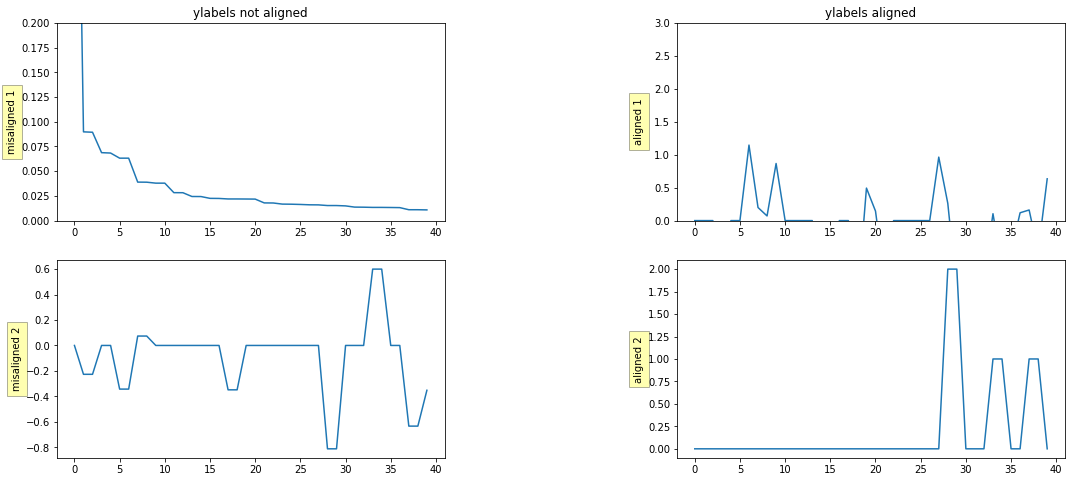

In [5]:
def make_plot(axs):
    box = dict(facecolor='yellow', pad=5, alpha=0.3)

    # Fixing random state for reproducibility
    np.random.seed(19680801)
    ax1 = axs[0, 0]
    ax1.plot(mags[0:40])
    ax1.set_title('ylabels not aligned')
    ax1.set_ylabel('misaligned 1', bbox=box)
    ax1.set_ylim(0, .2)

    ax3 = axs[1, 0]
    ax3.set_ylabel('misaligned 2', bbox=box)
    ax3.plot(phases[0:40])

    ax2 = axs[0, 1]
    ax2.set_title('ylabels aligned')
    ax2.plot(sigs[0:40])
    ax2.set_ylabel('aligned 1', bbox=box)
    ax2.set_ylim(0, 3)

    ax4 = axs[1, 1]
    ax4.plot(sectors[0:40])
    ax4.set_ylabel('aligned 2', bbox=box)


# Plot 1:
fig, axs = plt.subplots(2, 2,figsize=(20,8))
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs)

# just align the last column of axes:
fig.align_ylabels(axs[:, 1])
plt.show()

In [154]:
# Convert to pandas

pd_dataset = pd.DataFrame({'Magnitude': mags, 'Phase': phases, 'Signature Angle': sigs, 'Sector': sectors, 'Distance': distances})
pd_dataset.head(10)

,Magnitude,Phase,Signature Angle,Sector,Distance
0,0.622711,0.000000,2.628554,0.0,0.000000
1,0.108877,-0.052583,-1.301212,0.0,19.026298
2,0.108278,-0.052583,0.000000,0.0,19.026298
3,0.058562,0.000000,-0.705795,0.0,19.000000
4,0.058225,0.000000,0.000000,0.0,19.000000
5,0.051744,-0.058756,0.000000,0.0,34.058773
6,0.051547,-0.058756,0.612050,0.0,34.058773
7,0.034459,0.000000,0.829230,0.0,35.000000
8,0.034441,0.000000,0.000000,0.0,35.000000
9,0.033220,0.000000,0.000000,0.0,50.000000


In [57]:
len(mags[0:200])

200

In [4]:
# Correlation between columns

corr_matrix = pd_dataset.corr()
plt.figure(figsize=(9, 8))
sns.heatmap(data = corr_matrix,cmap='BrBG', annot=True, linewidths=0.2)

NameError: name 'pd_dataset' is not defined

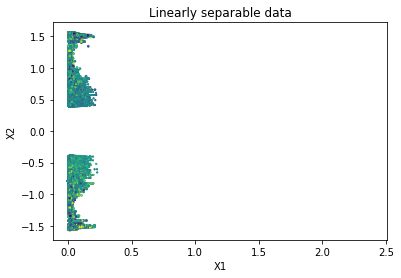

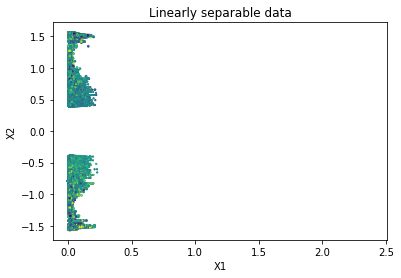

In [5]:
# Plot linear relationship

plt.scatter(mags, phases, sectors, sigs)
plt.title('Linearly separable data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

plt.scatter(mags, phases, sectors, sigs)
plt.title('Linearly separable data')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [4]:

feature_map.shape

(38310, 200, 1)

In [5]:
classes.shape

(38310,)

In [6]:
# Generate batch of features
group = len(feature_map)/BATCH_SIZE

batch_features = np.split(feature_map, group)
batch_features = np.array(batch_features)
batch_features = torch.from_numpy(batch_features).float()

batch_features.shape

torch.Size([7662, 5, 200, 1])

In [7]:
# Generate batch of classes
group = len(classes)/BATCH_SIZE

batch_classes = np.split(classes, group)
batch_classes = np.array(batch_classes)
batch_classes = torch.from_numpy(batch_classes).long()

batch_classes.shape

torch.Size([7662, 5])

In [24]:
# Set training device: CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [9]:
# Fully Connected Neural Network (FCCN) Architecture

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.classifier = nn.Sequential(
            
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),
            nn.Dropout(0.10),
            nn.ReLU(),
            
            nn.Linear(200, 150),
            nn.BatchNorm1d(150),
            nn.Dropout(0.10),
            nn.ReLU(),
            
            nn.Linear(150, 100),
            nn.BatchNorm1d(100),
            #nn.Dropout(0.15),
            nn.ReLU(),
            
            nn.Linear(100, 80),
            nn.BatchNorm1d(80),
            #nn.Dropout(0.1),
            nn.ReLU(),
            
            nn.Linear(80, 60),
            nn.BatchNorm1d(60),
            #nn.Dropout(0.1),
            nn.ReLU(),
            
            nn.Linear(60, 50),
            nn.BatchNorm1d(50),
            #nn.Dropout(0.1),
            nn.ReLU(),
            
            nn.Linear(50, 30),
            nn.BatchNorm1d(30),
            #nn.Dropout(0.07),
            nn.ReLU(),
            
            nn.Linear(30, 2),
            #nn.Softmax(dim=1)
            nn.Sigmoid()
            
        )
        
    def forward(self, x):
        x = x.view(-1, 200)
        
        x = self.classifier(x)
        
        return x


net = Net()
net = net.float()
net.to(device)

Net(
  (classifier): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=150, bias=True)
    (5): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=150, out_features=100, bias=True)
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=100, out_features=80, bias=True)
    (12): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Linear(in_features=80, out_features=60, bias=True)
    (15): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): Linear(in_features=60, out_features=5

In [10]:
# Loss function configuration

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM) #, weight_decay=0.001

In [11]:
# Training data on GPU

train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

print('Training started...\n')

for epoch in range(TOTAL_EPOCH):  # loop over the dataset multiple times

    running_loss = 0.0
    end_loss = 0.0
    j = 0
    
    y_hat_classes = []
    
    for i in range(0, len(batch_features)):
        
        print('\rEPOCH ' + str(epoch+1) + '/'+str(TOTAL_EPOCH)+': Batch ' + str(i+1) + '/' + str(len(batch_features)), end='')
        
        inputs = batch_features[i].to(device)
        labels = batch_classes[i].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print(outputs)
        
        # print statistics
        running_loss += loss.item()
        end_loss= loss.item()
        
        j += 1
        
        #y_hat_class = np.where(outputs.detach().cpu().numpy()<0.5, 0, 1)
        _, predicted = torch.max(outputs, 1)
        y_hat_class = predicted.cpu().numpy()
        
        #y_hat_classes.append(y_hat_class[0][1])
        #y_hat_classes.append(y_hat_class[1][1])
        y_hat_classes.append(y_hat_class)
        
    avg_loss = running_loss/j
    
    y_hat_classes = np.array(y_hat_classes)
    accuracy = np.sum(classes.reshape(-1,1)==y_hat_classes.reshape(-1,1)) / len(classes.reshape(-1,1))
    
    train_accuracy.append(accuracy)
    train_loss.append(avg_loss)

    print('\nEPOCH ' + str(epoch+1) + '/'+str(TOTAL_EPOCH)+'(DONE): ' + 'Loss = ' + str(avg_loss) + 
          '  Accuracy = ' + str(accuracy) + 
          ' (' + 'GPU: cuda:0 - ' + torch.cuda.get_device_name(0) + ')\n')

print('\nFinished Training')

Training started...

EPOCH 1/200: Batch 7662/7662
EPOCH 1/200(DONE): Loss = 0.5641698785237064  Accuracy = 0.7476637953536935 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 2/200: Batch 7662/7662
EPOCH 2/200(DONE): Loss = 0.5497842518896199  Accuracy = 0.7512398851474811 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 3/200: Batch 7662/7662
EPOCH 3/200(DONE): Loss = 0.5482758886740682  Accuracy = 0.7512398851474811 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 4/200: Batch 7662/7662
EPOCH 4/200(DONE): Loss = 0.5473038694451541  Accuracy = 0.7512398851474811 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 5/200: Batch 7662/7662
EPOCH 5/200(DONE): Loss = 0.5466865510744203  Accuracy = 0.7512398851474811 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 6/200: Batch 7662/7662
EPOCH 6/200(DONE): Loss = 0.5442530925343597  Accuracy = 0.7512398851474811 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 7/200: Batch 7662/7662
EPOCH 7/200(DONE): Loss = 0.5434410873303617  Accuracy = 0.7512398851474811 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 

EPOCH 117/200: Batch 7662/7662
EPOCH 117/200(DONE): Loss = 0.45910816962695317  Accuracy = 0.8526494387888279 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 118/200: Batch 7662/7662
EPOCH 118/200(DONE): Loss = 0.4586239538268052  Accuracy = 0.8527016444792482 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 119/200: Batch 7662/7662
EPOCH 119/200(DONE): Loss = 0.45857871525890054  Accuracy = 0.8524145131819368 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 120/200: Batch 7662/7662
EPOCH 120/200(DONE): Loss = 0.4577490329641301  Accuracy = 0.8539023753589141 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 121/200: Batch 7662/7662
EPOCH 121/200(DONE): Loss = 0.45720793451910635  Accuracy = 0.8538501696684939 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 122/200: Batch 7662/7662
EPOCH 122/200(DONE): Loss = 0.45929466778399336  Accuracy = 0.8515009135995824 (GPU: cuda:0 - GeForce GTX 1050)

EPOCH 123/200: Batch 7662/7662
EPOCH 123/200(DONE): Loss = 0.45519858785411205  Accuracy = 0.8566431741059776 (GPU: cuda:0 - GeForce GTX 1

In [182]:
#len(batch_features)
#Training starts at 4.00am

In [12]:
outputs

tensor([[1.3688e-14, 1.0000e+00],
        [4.1231e-07, 1.0000e+00],
        [9.6480e-17, 1.0000e+00],
        [9.9564e-01, 4.3865e-03],
        [9.9537e-01, 4.6828e-03]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [13]:
#y_hat_class

In [14]:
#len(y_hat_classes.reshape(-1,1))

In [15]:
#classes.reshape(-1,1)

In [16]:
#y_hat_classes.reshape(-1,1)

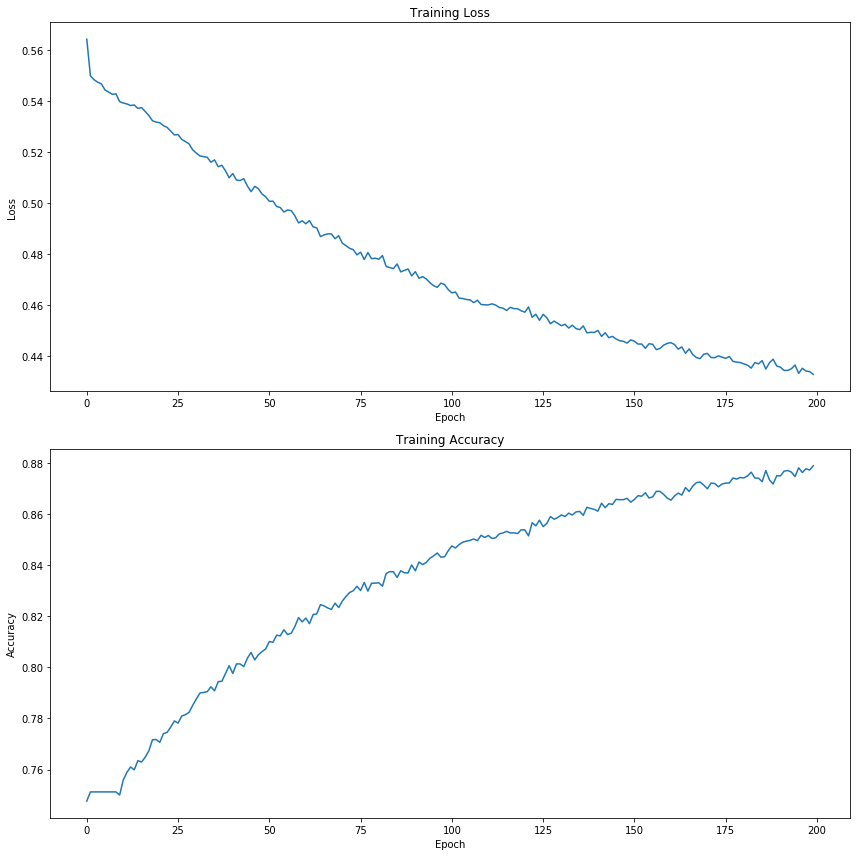

In [17]:
# Training accuracy and loss plotting

fig, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].plot(train_loss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(train_accuracy)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

In [19]:
# Save trained model

PATH = 'D:/SCA/256_256/nn_output/trained_model.nn'
torch.save(net.state_dict(), PATH)

In [20]:
test_feature_map.shape

torch.Size([7774, 200, 1])

In [21]:
test_files_title[0]

'10_50_1_c_100_178.txt'

In [22]:
test_classes.size(0)

7774

In [179]:
# Load saved model

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [42]:
# Compute neural network output

outputs = net(test_feature_map.to(device))
outputs

tensor([[5.7834e-04, 9.9963e-01],
        [2.7661e-06, 1.0000e+00],
        [9.9367e-01, 6.4557e-03],
        ...,
        [1.7626e-14, 1.0000e+00],
        [2.4671e-01, 7.8093e-01],
        [6.5616e-01, 3.4973e-01]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [43]:
# The outputs are energies for 2 classes. 
# The higher the energy for a class, the more the network thinks that the feature is of the particular class. 
# Get the index of the highest energy

_, predicted = torch.max(outputs, 1)
nd_predict = predicted.cpu().numpy()
predicted

tensor([1, 1, 0,  ..., 1, 1, 0], device='cuda:0')

In [44]:
test_classes.shape

torch.Size([8222])

In [45]:
# Compute Accuracy on test result

correct = 0
total = 0

with torch.no_grad():
    
    total = test_classes.size(0)
    correct = (nd_predict == test_classes.numpy()).sum().item()
    
acc = (correct / total)

print('Accuracy on '+ str(total) +' testset: ' + str(acc))

Accuracy on 8222 testset: 0.6495986378010217


In [46]:
# Confusion matrix
# confusion_matrix(y_true, y_pred)

results = confusion_matrix(nd_predict, test_classes.numpy(), labels=[0, 1])

print('Confusion Matrix :')
print(results) 
#print('Accuracy Score :',accuracy_score(test_classes, predicted))
#print('Report : ')
#print(classification_report(test_classes, predicted))

Confusion Matrix :
[[1194 1272]
 [1609 4147]]


In [54]:
#Individual class accuracy
# Catheter = 1, Echo = 0

total_cat = 0
pred_cat = 0

total_echo = 0
pred_echo = 0

with torch.no_grad():
    
    _, predicted = torch.max(outputs, 1)
    c = (nd_predict == test_classes.numpy()).squeeze()
    
    for i in range(0, len(nd_predict)):
        l = test_classes[i]
        
        if l == 0:
            total_echo += 1
        if nd_predict[i] == 0:
            pred_echo += 1
            
        if l == 1:
            total_cat += 1
        if nd_predict[i] == 1:
            pred_cat += 1

print('Accuracy of Catheter = ' + str(pred_cat / total_cat))
print('Accuracy of Echo = ' + str(pred_echo / total_echo))

Accuracy of Catheter = 1.0621885956818602
Accuracy of Echo = 0.8797716732072779


In [53]:
c

array([ True,  True, False, ...,  True,  True,  True])

In [56]:
# Write NN output


image_slice = 0
xys = []
r_path = 'D:/SCA/256_256/nn_output/bounding_boxes/'

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

#len(nd_predict)
for i in range(0, len(nd_predict)):
    
    print(test_files_title[i])
    f_arr = test_files_title[i].split('_')
    
    p_sl = f_arr[0]
    i_s = f_arr[1]
    i_sub = f_arr[2]
    o_type = f_arr[3]
    x_val = f_arr[4]
    y_val = f_arr[5].split('.')[0]
    
    img_path = r_path + p_sl + '/'+ i_s + '_' + i_sub +'.png'
    imgcv = cv2.imread(img_path)
    
    x1 = int(x_val)-16
    y1 = int(y_val)-16
    x2 = int(x_val)+16
    y2 = int(y_val)+16
    
    #conf = 0.99
    
    #label = 'C' if nd_predict[i] == 1 else 'E'
    label = 'C' if o_type == 'c' else 'E'
    
    cv2.rectangle(imgcv,(x1,y1),(x2,y2),(0,255,0),1)
    
    labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,0.4,2)
    
    _x1 = x1
    _y1 = y1
    _x2 = _x1+labelSize[0][0]
    _y2 = y1-int(labelSize[0][1])
    
    cv2.rectangle(imgcv,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
    cv2.putText(imgcv,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.4,(0,0,0),1)
    
    cv2.imwrite(img_path,imgcv)

10_50_1_c_100_178.txt
10_50_1_c_104_134.txt
10_50_1_c_106_218.txt
10_50_1_c_138_145.txt
10_50_1_c_158_216.txt
10_50_1_c_174_74.txt
10_50_1_c_228_82.txt
10_50_1_e_161_24.txt
10_50_1_e_206_44.txt
10_50_1_e_211_152.txt
10_50_1_e_222_44.txt
10_50_1_e_31_209.txt
10_50_1_e_94_41.txt
10_50_2_c_120_206.txt
10_50_2_c_167_146.txt
10_50_2_c_22_211.txt
10_50_2_c_42_73.txt
10_50_2_c_98_82.txt
10_50_2_c_99_232.txt
10_50_2_e_101_44.txt
10_50_2_e_169_211.txt
10_50_2_e_37_48.txt
10_50_2_e_87_158.txt
10_51_1_c_108_223.txt
10_51_1_c_140_146.txt
10_51_1_c_148_88.txt
10_51_1_c_153_210.txt
10_51_1_c_172_76.txt
10_51_1_c_226_80.txt
10_51_1_c_94_183.txt
10_51_1_c_98_132.txt
10_51_1_e_102_45.txt
10_51_1_e_162_26.txt
10_51_1_e_200_16.txt
10_51_1_e_206_155.txt
10_51_1_e_38_203.txt
10_51_2_c_170_146.txt
10_51_2_c_48_73.txt
10_51_2_c_99_84.txt
10_51_2_e_110_22.txt
10_51_2_e_128_58.txt
10_51_2_e_28_30.txt
10_51_2_e_54_124.txt
10_51_2_e_67_19.txt
10_51_2_e_71_156.txt
10_51_2_e_83_44.txt
10_52_1_c_100_178.txt
10_52_1

10_66_2_e_94_38.txt
10_67_1_c_102_180.txt
10_67_1_c_104_135.txt
10_67_1_c_112_223.txt
10_67_1_c_139_146.txt
10_67_1_c_164_211.txt
10_67_1_c_173_76.txt
10_67_1_c_224_232.txt
10_67_1_c_226_83.txt
10_67_1_e_114_61.txt
10_67_1_e_142_43.txt
10_67_1_e_190_27.txt
10_67_1_e_206_157.txt
10_67_1_e_222_36.txt
10_67_1_e_46_201.txt
10_67_1_e_68_84.txt
10_67_2_c_119_206.txt
10_67_2_c_162_207.txt
10_67_2_c_165_146.txt
10_67_2_c_42_211.txt
10_67_2_c_48_72.txt
10_67_2_c_96_232.txt
10_67_2_c_97_84.txt
10_67_2_e_130_32.txt
10_67_2_e_207_219.txt
10_67_2_e_34_36.txt
10_67_2_e_75_153.txt
10_67_2_e_99_41.txt
10_68_1_c_100_138.txt
10_68_1_c_100_181.txt
10_68_1_c_146_148.txt
10_68_1_c_156_213.txt
10_68_1_c_174_76.txt
10_68_1_c_224_84.txt
10_68_1_e_109_68.txt
10_68_1_e_162_40.txt
10_68_1_e_215_38.txt
10_68_1_e_34_228.txt
10_68_1_e_49_193.txt
10_68_1_e_71_88.txt
10_68_2_c_102_84.txt
10_68_2_c_103_232.txt
10_68_2_c_122_211.txt
10_68_2_c_14_148.txt
10_68_2_c_168_151.txt
10_68_2_c_44_75.txt
10_68_2_e_132_33.txt
10_

14_59_1_e_55_208.txt
14_59_2_c_122_143.txt
14_59_2_c_122_196.txt
14_59_2_c_134_116.txt
14_59_2_c_145_238.txt
14_59_2_c_167_158.txt
14_59_2_c_23_154.txt
14_59_2_c_30_211.txt
14_59_2_c_35_88.txt
14_59_2_c_90_81.txt
14_59_2_e_112_27.txt
14_59_2_e_163_88.txt
14_59_2_e_195_200.txt
14_59_2_e_36_16.txt
14_59_2_e_65_167.txt
14_59_2_e_72_222.txt
14_60_1_c_108_118.txt
14_60_1_c_110_148.txt
14_60_1_c_154_154.txt
14_60_1_c_162_205.txt
14_60_1_c_168_91.txt
14_60_1_c_222_82.txt
14_60_1_e_110_188.txt
14_60_1_e_170_13.txt
14_60_1_e_172_57.txt
14_60_1_e_180_140.txt
14_60_1_e_198_168.txt
14_60_1_e_60_185.txt
14_60_2_c_122_140.txt
14_60_2_c_122_201.txt
14_60_2_c_126_201.txt
14_60_2_c_130_114.txt
14_60_2_c_142_232.txt
14_60_2_c_164_159.txt
14_60_2_c_167_194.txt
14_60_2_c_22_156.txt
14_60_2_c_29_211.txt
14_60_2_c_34_91.txt
14_60_2_c_89_84.txt
14_60_2_e_111_65.txt
14_60_2_e_112_30.txt
14_60_2_e_190_208.txt
14_60_2_e_202_157.txt
14_60_2_e_34_58.txt
14_60_2_e_35_20.txt
14_60_2_e_66_168.txt
14_60_2_e_77_217.tx

15_54_1_e_158_110.txt
15_54_1_e_166_18.txt
15_54_1_e_167_200.txt
15_54_1_e_190_164.txt
15_54_1_e_190_43.txt
15_54_1_e_228_106.txt
15_54_1_e_82_84.txt
15_54_2_c_114_156.txt
15_54_2_c_150_218.txt
15_54_2_c_156_173.txt
15_54_2_c_98_183.txt
15_54_2_e_125_136.txt
15_54_2_e_129_28.txt
15_54_2_e_216_228.txt
15_54_2_e_31_188.txt
15_54_2_e_34_19.txt
15_54_2_e_50_44.txt
15_54_2_e_76_192.txt
15_54_2_e_87_24.txt
15_54_2_e_90_64.txt
15_55_1_c_119_124.txt
15_55_1_c_133_192.txt
15_55_1_c_171_87.txt
15_55_1_c_230_229.txt
15_55_1_c_83_163.txt
15_55_1_e_14_178.txt
15_55_1_e_157_17.txt
15_55_1_e_167_200.txt
15_55_1_e_186_46.txt
15_55_1_e_190_162.txt
15_55_1_e_203_193.txt
15_55_1_e_227_63.txt
15_55_1_e_79_82.txt
15_55_2_c_102_228.txt
15_55_2_c_112_156.txt
15_55_2_c_158_172.txt
15_55_2_c_96_181.txt
15_55_2_e_106_69.txt
15_55_2_e_124_136.txt
15_55_2_e_134_29.txt
15_55_2_e_214_226.txt
15_55_2_e_30_197.txt
15_55_2_e_56_44.txt
15_55_2_e_57_43.txt
15_56_1_c_118_123.txt
15_56_1_c_130_192.txt
15_56_1_c_170_86.txt

16_54_2_e_79_82.txt
16_55_1_c_110_184.txt
16_55_1_c_117_156.txt
16_55_1_c_134_216.txt
16_55_1_c_152_109.txt
16_55_1_c_157_189.txt
16_55_1_c_230_206.txt
16_55_1_e_136_92.txt
16_55_1_e_169_80.txt
16_55_1_e_171_241.txt
16_55_1_e_220_88.txt
16_55_1_e_233_142.txt
16_55_1_e_92_228.txt
16_55_2_c_110_204.txt
16_55_2_c_141_127.txt
16_55_2_c_22_108.txt
16_55_2_c_22_189.txt
16_55_2_e_103_141.txt
16_55_2_e_166_148.txt
16_55_2_e_169_104.txt
16_55_2_e_78_203.txt
16_55_2_e_78_83.txt
16_55_2_e_93_60.txt
16_56_1_c_113_184.txt
16_56_1_c_118_152.txt
16_56_1_c_123_153.txt
16_56_1_c_134_219.txt
16_56_1_c_150_189.txt
16_56_1_c_151_117.txt
16_56_1_c_232_207.txt
16_56_1_c_237_164.txt
16_56_1_e_205_85.txt
16_56_1_e_221_57.txt
16_56_1_e_234_144.txt
16_56_1_e_95_231.txt
16_56_2_c_104_209.txt
16_56_2_c_110_168.txt
16_56_2_c_146_131.txt
16_56_2_c_150_210.txt
16_56_2_c_22_189.txt
16_56_2_c_23_108.txt
16_56_2_e_103_144.txt
16_56_2_e_149_208.txt
16_56_2_e_168_106.txt
16_56_2_e_81_84.txt
16_56_2_e_86_58.txt
16_57_1_c_

17_53_1_c_168_68.txt
17_53_1_c_219_219.txt
17_53_1_c_222_189.txt
17_53_1_c_231_81.txt
17_53_1_c_87_156.txt
17_53_1_c_98_200.txt
17_53_1_e_138_155.txt
17_53_1_e_166_68.txt
17_53_1_e_224_191.txt
17_53_1_e_231_220.txt
17_53_1_e_239_79.txt
17_53_1_e_86_156.txt
17_53_1_e_95_206.txt
17_53_2_c_104_80.txt
17_53_2_c_138_213.txt
17_53_2_c_142_147.txt
17_53_2_c_23_152.txt
17_53_2_c_42_68.txt
17_53_2_c_89_220.txt
17_53_2_c_99_188.txt
17_53_2_e_100_191.txt
17_53_2_e_100_220.txt
17_53_2_e_102_80.txt
17_53_2_e_128_214.txt
17_53_2_e_141_144.txt
17_53_2_e_18_153.txt
17_53_2_e_33_67.txt
17_54_1_c_137_156.txt
17_54_1_c_162_67.txt
17_54_1_c_218_216.txt
17_54_1_c_222_185.txt
17_54_1_c_222_79.txt
17_54_1_c_89_152.txt
17_54_1_c_94_205.txt
17_54_1_e_139_155.txt
17_54_1_e_167_68.txt
17_54_1_e_227_193.txt
17_54_1_e_228_216.txt
17_54_1_e_236_80.txt
17_54_1_e_83_158.txt
17_54_1_e_97_202.txt
17_54_2_c_102_80.txt
17_54_2_c_138_212.txt
17_54_2_c_140_148.txt
17_54_2_c_26_150.txt
17_54_2_c_36_65.txt
17_54_2_c_88_219.t

17_67_1_c_94_153.txt
17_67_1_e_102_199.txt
17_67_1_e_135_162.txt
17_67_1_e_162_72.txt
17_67_1_e_216_193.txt
17_67_1_e_218_221.txt
17_67_1_e_225_85.txt
17_67_1_e_92_155.txt
17_67_2_c_104_84.txt
17_67_2_c_130_211.txt
17_67_2_c_139_156.txt
17_67_2_c_20_156.txt
17_67_2_c_25_232.txt
17_67_2_c_39_73.txt
17_67_2_c_94_195.txt
17_67_2_c_97_220.txt
17_67_2_e_102_81.txt
17_67_2_e_128_212.txt
17_67_2_e_135_152.txt
17_67_2_e_26_154.txt
17_67_2_e_42_72.txt
17_67_2_e_94_225.txt
17_67_2_e_95_196.txt
17_68_1_c_100_202.txt
17_68_1_c_142_160.txt
17_68_1_c_146_231.txt
17_68_1_c_170_76.txt
17_68_1_c_221_222.txt
17_68_1_c_223_194.txt
17_68_1_c_228_84.txt
17_68_1_c_86_160.txt
17_68_1_e_100_203.txt
17_68_1_e_136_159.txt
17_68_1_e_218_195.txt
17_68_1_e_222_220.txt
17_68_1_e_231_84.txt
17_68_1_e_86_156.txt
17_68_2_c_103_83.txt
17_68_2_c_139_149.txt
17_68_2_c_16_158.txt
17_68_2_c_19_233.txt
17_68_2_c_42_72.txt
17_68_2_c_94_219.txt
17_68_2_c_96_194.txt
17_68_2_e_102_83.txt
17_68_2_e_130_212.txt
17_68_2_e_138_148.

18_68_2_c_158_220.txt
18_68_2_c_34_94.txt
18_68_2_c_49_70.txt
18_68_2_e_105_69.txt
18_68_2_e_114_174.txt
18_68_2_e_117_213.txt
18_68_2_e_134_140.txt
18_68_2_e_161_220.txt
18_68_2_e_164_149.txt
18_68_2_e_41_67.txt
18_69_1_c_131_138.txt
18_69_1_c_141_94.txt
18_69_1_c_142_217.txt
18_69_1_c_166_68.txt
18_69_1_e_114_176.txt
18_69_1_e_133_140.txt
18_69_1_e_142_95.txt
18_69_1_e_143_217.txt
18_69_1_e_161_68.txt
18_69_1_e_82_196.txt
18_69_1_e_87_149.txt
18_69_2_c_102_72.txt
18_69_2_c_111_173.txt
18_69_2_c_155_217.txt
18_69_2_c_43_72.txt
18_69_2_e_108_68.txt
18_69_2_e_114_214.txt
18_69_2_e_117_176.txt
18_69_2_e_133_144.txt
18_69_2_e_158_216.txt
18_69_2_e_165_153.txt
18_69_2_e_42_68.txt
18_70_1_c_135_97.txt
18_70_1_c_137_136.txt
18_70_1_c_167_73.txt
18_70_1_e_116_176.txt
18_70_1_e_133_140.txt
18_70_1_e_143_93.txt
18_70_1_e_150_220.txt
18_70_1_e_167_68.txt
18_70_1_e_89_198.txt
18_70_2_c_110_215.txt
18_70_2_c_119_172.txt
18_70_2_c_151_214.txt
18_70_2_c_39_71.txt
18_70_2_e_110_69.txt
18_70_2_e_115_2

36_64_2_c_106_219.txt
36_64_2_c_122_108.txt
36_64_2_c_149_136.txt
36_64_2_c_163_200.txt
36_64_2_c_93_60.txt
36_64_2_e_187_104.txt
36_64_2_e_38_178.txt
36_65_1_c_114_142.txt
36_65_1_c_114_216.txt
36_65_1_c_118_96.txt
36_65_1_c_122_191.txt
36_65_1_c_219_60.txt
36_65_1_c_228_150.txt
36_65_1_c_232_213.txt
36_65_1_c_78_186.txt
36_65_1_c_82_152.txt
36_65_1_e_176_185.txt
36_65_2_c_106_154.txt
36_65_2_c_112_216.txt
36_65_2_c_126_112.txt
36_65_2_c_150_138.txt
36_65_2_c_162_200.txt
36_65_2_c_97_60.txt
36_65_2_e_186_104.txt
36_65_2_e_42_181.txt
36_66_1_c_114_218.txt
36_66_1_c_115_141.txt
36_66_1_c_121_100.txt
36_66_1_c_121_194.txt
36_66_1_c_143_72.txt
36_66_1_c_218_61.txt
36_66_1_c_231_151.txt
36_66_1_c_233_215.txt
36_66_1_c_82_191.txt
36_66_1_e_170_182.txt
36_66_2_c_101_152.txt
36_66_2_c_104_211.txt
36_66_2_c_119_110.txt
36_66_2_c_146_140.txt
36_66_2_c_88_63.txt
36_66_2_e_179_100.txt
36_66_2_e_46_187.txt
36_67_1_c_112_216.txt
36_67_1_c_114_104.txt
36_67_1_c_116_144.txt
36_67_1_c_125_190.txt
36_6

3_65_1_e_114_72.txt
3_65_1_e_117_46.txt
3_65_1_e_179_86.txt
3_65_1_e_185_56.txt
3_65_1_e_212_29.txt
3_65_2_c_109_216.txt
3_65_2_c_13_227.txt
3_65_2_c_20_197.txt
3_65_2_c_21_174.txt
3_65_2_c_32_104.txt
3_65_2_c_66_102.txt
3_65_2_e_106_88.txt
3_65_2_e_134_28.txt
3_65_2_e_50_88.txt
3_65_2_e_52_56.txt
3_65_2_e_92_28.txt
3_66_1_c_138_228.txt
3_66_1_c_142_199.txt
3_66_1_c_151_174.txt
3_66_1_c_162_104.txt
3_66_1_c_196_102.txt
3_66_1_c_233_214.txt
3_66_1_e_105_102.txt
3_66_1_e_110_66.txt
3_66_1_e_114_36.txt
3_66_1_e_167_16.txt
3_66_1_e_184_57.txt
3_66_1_e_226_27.txt
3_66_2_c_109_216.txt
3_66_2_c_116_198.txt
3_66_2_c_14_224.txt
3_66_2_c_20_198.txt
3_66_2_c_22_172.txt
3_66_2_c_39_102.txt
3_66_2_c_66_100.txt
3_66_2_e_130_28.txt
3_66_2_e_47_84.txt
3_66_2_e_84_28.txt
3_67_1_c_138_226.txt
3_67_1_c_144_198.txt
3_67_1_c_152_174.txt
3_67_1_c_162_104.txt
3_67_1_c_197_100.txt
3_67_1_c_235_214.txt
3_67_1_e_109_72.txt
3_67_1_e_110_102.txt
3_67_1_e_120_43.txt
3_67_1_e_172_23.txt
3_67_1_e_181_59.txt
3_67_1_e

43_66_2_c_45_92.txt
43_66_2_e_105_78.txt
43_66_2_e_138_48.txt
43_66_2_e_171_76.txt
43_67_1_c_134_109.txt
43_67_1_c_150_216.txt
43_67_1_c_156_152.txt
43_67_1_c_176_94.txt
43_67_1_e_101_76.txt
43_67_1_e_152_39.txt
43_67_1_e_35_206.txt
43_67_2_c_120_94.txt
43_67_2_c_127_172.txt
43_67_2_c_22_154.txt
43_67_2_c_50_94.txt
43_67_2_e_119_22.txt
43_67_2_e_177_72.txt
43_67_2_e_85_121.txt
43_68_1_c_104_204.txt
43_68_1_c_136_104.txt
43_68_1_c_142_222.txt
43_68_1_c_153_146.txt
43_68_1_c_184_97.txt
43_68_1_c_84_154.txt
43_68_1_e_111_75.txt
43_68_1_e_159_36.txt
43_68_1_e_214_142.txt
43_68_2_c_113_101.txt
43_68_2_c_123_172.txt
43_68_2_c_24_156.txt
43_68_2_c_48_94.txt
43_68_2_e_114_24.txt
43_68_2_e_163_70.txt
43_68_2_e_76_140.txt
43_69_1_c_103_202.txt
43_69_1_c_139_110.txt
43_69_1_c_160_156.txt
43_69_1_c_186_96.txt
43_69_1_e_110_70.txt
43_69_1_e_212_144.txt
43_69_1_e_229_72.txt
43_69_2_c_116_101.txt
43_69_2_c_121_174.txt
43_69_2_c_29_152.txt
43_69_2_c_50_95.txt
43_69_2_e_116_43.txt
43_69_2_e_178_78.txt


52_64_1_c_114_113.txt
52_64_1_c_155_146.txt
52_64_1_c_156_102.txt
52_64_1_c_165_186.txt
52_64_1_c_236_112.txt
52_64_1_e_102_53.txt
52_64_1_e_115_75.txt
52_64_1_e_185_120.txt
52_64_1_e_201_149.txt
52_64_1_e_49_208.txt
52_64_1_e_79_99.txt
52_64_2_c_122_170.txt
52_64_2_c_158_120.txt
52_64_2_c_24_99.txt
52_64_2_c_34_146.txt
52_64_2_c_36_185.txt
52_64_2_c_78_202.txt
52_64_2_e_116_212.txt
52_64_2_e_149_62.txt
52_64_2_e_171_45.txt
52_64_2_e_177_116.txt
52_64_2_e_218_145.txt
52_64_2_e_49_117.txt
52_64_2_e_90_154.txt
52_65_1_c_112_116.txt
52_65_1_c_160_105.txt
52_65_1_c_162_188.txt
52_65_1_c_166_139.txt
52_65_1_c_180_211.txt
52_65_1_c_213_206.txt
52_65_1_e_186_118.txt
52_65_1_e_204_148.txt
52_65_1_e_46_219.txt
52_65_1_e_94_45.txt
52_65_2_c_112_114.txt
52_65_2_c_122_173.txt
52_65_2_c_131_74.txt
52_65_2_c_162_123.txt
52_65_2_c_22_101.txt
52_65_2_c_36_144.txt
52_65_2_c_74_201.txt
52_65_2_e_151_62.txt
52_65_2_e_156_21.txt
52_65_2_e_174_49.txt
52_65_2_e_216_148.txt
52_65_2_e_54_117.txt
52_66_1_c_112

59_61_2_e_38_58.txt
59_61_2_e_71_146.txt
59_62_1_c_104_189.txt
59_62_1_c_126_209.txt
59_62_1_c_132_149.txt
59_62_1_c_142_122.txt
59_62_1_c_156_194.txt
59_62_1_c_157_74.txt
59_62_1_c_205_209.txt
59_62_1_c_206_58.txt
59_62_1_c_229_142.txt
59_62_1_e_168_60.txt
59_62_1_e_170_25.txt
59_62_1_e_206_164.txt
59_62_2_c_105_147.txt
59_62_2_c_121_176.txt
59_62_2_c_124_206.txt
59_62_2_c_128_112.txt
59_62_2_c_32_76.txt
59_62_2_c_38_190.txt
59_62_2_c_80_209.txt
59_62_2_c_88_59.txt
59_62_2_e_38_27.txt
59_62_2_e_38_58.txt
59_62_2_e_73_162.txt
59_63_1_c_107_196.txt
59_63_1_c_129_214.txt
59_63_1_c_136_128.txt
59_63_1_c_138_149.txt
59_63_1_c_160_72.txt
59_63_1_c_167_194.txt
59_63_1_c_206_62.txt
59_63_1_c_210_212.txt
59_63_1_c_228_146.txt
59_63_1_e_167_225.txt
59_63_1_e_170_23.txt
59_63_1_e_170_58.txt
59_63_1_e_203_164.txt
59_63_2_c_100_146.txt
59_63_2_c_121_177.txt
59_63_2_c_122_203.txt
59_63_2_c_126_110.txt
59_63_2_c_30_76.txt
59_63_2_c_37_190.txt
59_63_2_c_84_213.txt
59_63_2_c_92_64.txt
59_63_2_e_168_80

64_61_1_c_224_94.txt
64_61_1_c_236_144.txt
64_61_1_e_153_66.txt
64_61_2_c_106_146.txt
64_61_2_c_114_104.txt
64_61_2_c_119_203.txt
64_61_2_c_136_188.txt
64_61_2_c_140_116.txt
64_61_2_c_44_96.txt
64_61_2_c_64_84.txt
64_61_2_c_76_193.txt
64_61_2_c_98_96.txt
64_61_2_e_189_80.txt
64_61_2_e_26_62.txt
64_62_1_c_142_130.txt
64_62_1_c_150_221.txt
64_62_1_c_172_102.txt
64_62_1_c_193_88.txt
64_62_1_c_203_192.txt
64_62_1_c_223_94.txt
64_62_2_c_107_145.txt
64_62_2_c_114_105.txt
64_62_2_c_117_205.txt
64_62_2_c_135_193.txt
64_62_2_c_167_154.txt
64_62_2_c_42_103.txt
64_62_2_c_62_90.txt
64_62_2_c_74_193.txt
64_62_2_c_93_95.txt
64_62_2_e_122_128.txt
64_62_2_e_34_60.txt
64_62_2_e_86_229.txt
64_63_1_c_119_172.txt
64_63_1_c_141_134.txt
64_63_1_c_153_218.txt
64_63_1_c_174_100.txt
64_63_1_c_196_84.txt
64_63_1_c_203_192.txt
64_63_1_c_222_93.txt
64_63_1_c_239_142.txt
64_63_2_c_110_144.txt
64_63_2_c_115_108.txt
64_63_2_c_116_200.txt
64_63_2_c_134_114.txt
64_63_2_c_135_191.txt
64_63_2_c_14_130.txt
64_63_2_c_44_1

6_60_1_c_126_234.txt
6_60_1_c_143_196.txt
6_60_1_c_144_108.txt
6_60_1_c_155_121.txt
6_60_1_c_174_85.txt
6_60_1_c_204_226.txt
6_60_1_c_228_146.txt
6_60_1_c_238_204.txt
6_60_1_c_93_164.txt
6_60_1_e_120_84.txt
6_60_1_e_157_28.txt
6_60_1_e_161_174.txt
6_60_1_e_192_164.txt
6_60_1_e_76_117.txt
6_60_2_c_104_146.txt
6_60_2_c_116_206.txt
6_60_2_c_140_109.txt
6_60_2_c_172_138.txt
6_60_2_c_18_106.txt
6_60_2_c_18_193.txt
6_60_2_c_31_119.txt
6_60_2_c_52_84.txt
6_60_2_c_82_227.txt
6_60_2_e_127_61.txt
6_60_2_e_145_24.txt
6_60_2_e_180_80.txt
6_60_2_e_200_50.txt
6_60_2_e_30_56.txt
6_60_2_e_51_165.txt
6_61_1_c_125_234.txt
6_61_1_c_140_109.txt
6_61_1_c_143_196.txt
6_61_1_c_153_118.txt
6_61_1_c_207_228.txt
6_61_1_c_230_148.txt
6_61_1_c_238_200.txt
6_61_1_c_99_163.txt
6_61_1_e_159_52.txt
6_61_1_e_98_208.txt
6_61_2_c_100_148.txt
6_61_2_c_106_199.txt
6_61_2_c_140_115.txt
6_61_2_c_168_139.txt
6_61_2_c_16_108.txt
6_61_2_c_30_119.txt
6_61_2_c_43_83.txt
6_61_2_c_82_229.txt
6_61_2_e_122_62.txt
6_61_2_e_154_25.txt

72_56_1_c_125_189.txt
72_56_1_c_133_218.txt
72_56_1_c_147_132.txt
72_56_1_c_180_223.txt
72_56_1_c_218_77.txt
72_56_1_c_220_223.txt
72_56_1_c_232_174.txt
72_56_1_e_139_56.txt
72_56_1_e_188_143.txt
72_56_1_e_191_44.txt
72_56_2_c_104_169.txt
72_56_2_c_111_106.txt
72_56_2_c_153_166.txt
72_56_2_c_155_192.txt
72_56_2_c_158_123.txt
72_56_2_c_24_132.txt
72_56_2_c_55_219.txt
72_56_2_c_95_226.txt
72_56_2_c_95_86.txt
72_56_2_e_116_46.txt
72_56_2_e_60_48.txt
72_56_2_e_67_140.txt
72_57_1_c_124_195.txt
72_57_1_c_149_134.txt
72_57_1_c_150_134.txt
72_57_1_c_183_222.txt
72_57_1_c_215_86.txt
72_57_1_c_228_224.txt
72_57_1_e_151_56.txt
72_57_1_e_182_50.txt
72_57_1_e_195_139.txt
72_57_1_e_220_50.txt
72_57_2_c_108_173.txt
72_57_2_c_111_108.txt
72_57_2_c_116_65.txt
72_57_2_c_154_121.txt
72_57_2_c_156_166.txt
72_57_2_c_20_134.txt
72_57_2_c_56_220.txt
72_57_2_c_93_224.txt
72_57_2_c_93_84.txt
72_57_2_e_116_45.txt
72_57_2_e_49_46.txt
72_57_2_e_67_137.txt
72_57_2_e_76_66.txt
72_58_1_c_126_194.txt
72_58_1_c_152_13

81_51_2_c_144_113.txt
81_51_2_c_145_84.txt
81_51_2_c_147_164.txt
81_51_2_c_25_214.txt
81_51_2_c_28_62.txt
81_51_2_e_219_185.txt
81_51_2_e_50_152.txt
81_52_1_c_112_202.txt
81_52_1_c_120_163.txt
81_52_1_c_130_71.txt
81_52_1_c_154_59.txt
81_52_1_c_160_212.txt
81_52_1_c_226_56.txt
81_52_1_c_227_205.txt
81_52_1_e_181_147.txt
81_52_2_c_142_79.txt
81_52_2_c_146_115.txt
81_52_2_c_30_214.txt
81_52_2_c_95_204.txt
81_52_2_c_99_58.txt
81_52_2_e_219_183.txt
81_52_2_e_51_150.txt
81_53_1_c_119_166.txt
81_53_1_c_153_214.txt
81_53_1_c_156_185.txt
81_53_1_c_156_63.txt
81_53_1_c_229_204.txt
81_53_1_e_185_153.txt
81_53_2_c_100_56.txt
81_53_2_c_146_163.txt
81_53_2_c_147_114.txt
81_53_2_c_30_212.txt
81_53_2_c_99_208.txt
81_53_2_e_126_39.txt
81_53_2_e_51_152.txt
81_54_1_c_110_206.txt
81_54_1_c_119_164.txt
81_54_1_c_155_60.txt
81_54_1_c_160_184.txt
81_54_1_c_160_211.txt
81_54_1_c_228_205.txt
81_54_1_e_192_151.txt
81_54_2_c_101_59.txt
81_54_2_c_145_165.txt
81_54_2_c_148_113.txt
81_54_2_c_29_60.txt
81_54_2_c_30

87_57_1_c_179_196.txt
87_57_1_c_54_111.txt
87_57_1_c_90_182.txt
87_57_2_c_112_215.txt
87_57_2_c_116_42.txt
87_57_2_c_150_60.txt
87_57_2_c_169_135.txt
87_57_2_c_20_32.txt
87_57_2_c_20_78.txt
87_57_2_c_48_198.txt
87_58_1_c_126_93.txt
87_58_1_c_127_143.txt
87_58_1_c_131_58.txt
87_58_1_c_142_78.txt
87_58_1_c_146_36.txt
87_58_1_c_180_198.txt
87_58_1_c_241_47.txt
87_58_1_c_62_115.txt
87_58_1_c_88_185.txt
87_58_2_c_109_218.txt
87_58_2_c_116_46.txt
87_58_2_c_131_178.txt
87_58_2_c_144_58.txt
87_58_2_c_168_150.txt
87_58_2_c_175_119.txt
87_58_2_c_17_72.txt
87_58_2_c_25_33.txt
87_58_2_c_50_194.txt
87_59_1_c_127_96.txt
87_59_1_c_128_52.txt
87_59_1_c_135_148.txt
87_59_1_c_142_79.txt
87_59_1_c_144_33.txt
87_59_1_c_180_195.txt
87_59_1_c_240_42.txt
87_59_1_c_56_120.txt
87_59_1_c_85_184.txt
87_59_2_c_109_216.txt
87_59_2_c_116_214.txt
87_59_2_c_118_47.txt
87_59_2_c_146_55.txt
87_59_2_c_15_78.txt
87_59_2_c_168_136.txt
87_59_2_c_170_114.txt
87_59_2_c_17_27.txt
87_59_2_c_52_196.txt
87_60_1_c_128_56.txt
87_6

88_61_1_c_94_142.txt
88_61_2_c_111_172.txt
88_61_2_c_132_124.txt
88_61_2_c_148_216.txt
88_61_2_c_163_130.txt
88_61_2_c_164_176.txt
88_61_2_c_36_185.txt
88_61_2_c_40_62.txt
88_61_2_c_90_195.txt
88_62_1_c_102_139.txt
88_62_1_c_111_211.txt
88_62_1_c_121_119.txt
88_62_1_c_121_170.txt
88_62_1_c_152_189.txt
88_62_1_c_156_77.txt
88_62_1_c_170_64.txt
88_62_1_c_214_198.txt
88_62_2_c_101_176.txt
88_62_2_c_133_120.txt
88_62_2_c_146_206.txt
88_62_2_c_32_182.txt
88_62_2_c_35_66.txt
88_62_2_c_94_200.txt
88_63_1_c_100_142.txt
88_63_1_c_116_206.txt
88_63_1_c_119_118.txt
88_63_1_c_125_174.txt
88_63_1_c_156_76.txt
88_63_1_c_163_187.txt
88_63_1_c_168_68.txt
88_63_1_c_217_201.txt
88_63_2_c_112_173.txt
88_63_2_c_127_122.txt
88_63_2_c_147_210.txt
88_63_2_c_28_73.txt
88_63_2_c_32_184.txt
88_63_2_c_43_65.txt
88_63_2_c_90_202.txt
88_64_1_c_115_216.txt
88_64_1_c_116_116.txt
88_64_1_c_150_73.txt
88_64_1_c_158_184.txt
88_64_1_c_162_62.txt
88_64_1_c_216_198.txt
88_64_1_c_98_144.txt
88_64_2_c_108_174.txt
88_64_2_c_

92_63_1_c_217_82.txt
92_63_1_c_232_188.txt
92_63_1_e_146_50.txt
92_63_2_c_114_186.txt
92_63_2_c_157_210.txt
92_63_2_c_161_142.txt
92_63_2_c_162_174.txt
92_63_2_c_32_84.txt
92_63_2_c_91_214.txt
92_63_2_c_96_81.txt
92_63_2_e_114_46.txt
92_63_2_e_44_48.txt
92_64_1_c_102_134.txt
92_64_1_c_119_92.txt
92_64_1_c_144_204.txt
92_64_1_c_152_86.txt
92_64_1_c_222_78.txt
92_64_1_c_236_188.txt
92_64_1_e_138_49.txt
92_64_1_e_28_175.txt
92_64_2_c_113_189.txt
92_64_2_c_115_146.txt
92_64_2_c_156_142.txt
92_64_2_c_157_209.txt
92_64_2_c_166_174.txt
92_64_2_c_32_84.txt
92_64_2_c_90_79.txt
92_64_2_c_97_214.txt
92_64_2_e_111_52.txt
92_64_2_e_39_49.txt
92_65_1_c_101_134.txt
92_65_1_c_112_200.txt
92_65_1_c_118_92.txt
92_65_1_c_138_206.txt
92_65_1_c_155_84.txt
92_65_1_c_218_74.txt
92_65_1_e_139_49.txt
92_65_2_c_113_146.txt
92_65_2_c_117_191.txt
92_65_2_c_154_204.txt
92_65_2_c_158_137.txt
92_65_2_c_168_176.txt
92_65_2_c_32_86.txt
92_65_2_c_92_217.txt
92_65_2_c_93_82.txt
92_65_2_e_118_53.txt
92_65_2_e_40_45.txt
9

97_66_2_e_118_56.txt
97_67_1_c_104_170.txt
97_67_1_c_104_222.txt
97_67_1_c_149_220.txt
97_67_1_c_154_104.txt
97_67_1_c_168_80.txt
97_67_1_c_205_198.txt
97_67_2_c_104_94.txt
97_67_2_c_154_203.txt
97_67_2_c_157_158.txt
97_67_2_c_159_116.txt
97_67_2_c_28_213.txt
97_67_2_c_30_96.txt
97_67_2_c_45_72.txt
97_67_2_c_74_200.txt
97_67_2_e_107_65.txt
97_68_1_c_147_217.txt
97_68_1_c_155_101.txt
97_68_1_c_168_79.txt
97_68_1_c_206_196.txt
97_68_1_c_232_96.txt
97_68_1_c_97_219.txt
97_68_1_c_99_156.txt
97_68_2_c_106_97.txt
97_68_2_c_154_208.txt
97_68_2_c_160_118.txt
97_68_2_c_162_160.txt
97_68_2_c_21_212.txt
97_68_2_c_30_103.txt
97_68_2_c_37_78.txt
97_68_2_c_72_192.txt
97_68_2_e_106_65.txt
97_69_1_c_101_221.txt
97_69_1_c_157_216.txt
97_69_1_c_158_103.txt
97_69_1_c_168_74.txt
97_69_1_c_200_196.txt
97_69_1_c_233_94.txt
97_69_1_c_96_160.txt
97_69_2_c_107_92.txt
97_69_2_c_153_155.txt
97_69_2_c_156_113.txt
97_69_2_c_157_200.txt
97_69_2_c_22_102.txt
97_69_2_c_24_213.txt
97_69_2_c_37_75.txt
97_69_2_c_72_197.

In [39]:
nd_predict[0]

1